#### Сравните результат между тестом и контролем по двум кейсам:



In [19]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import seaborn as sns

In [6]:
#Считываем данные из CSV файла и записываем их в Pandas DataFrame
df = pd.read_csv('/home/jupyter-v.kotov-16/Lesson_9_stat/hw_bootstrap.csv', sep = ';', decimal = ',')

In [8]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control


In [11]:
#проверка на пропущенные значения
df.isna().sum()

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [97]:
# Разделение данных на контрольную и тестовую группу
df_control = df.query('experimentVariant == "Control"')

df_test_emissions = df.query('experimentVariant == "Treatment"')

In [98]:
#проверяем равенства количества строк
df_test_emissions.shape[0] == df_control.shape[0]

True

### Визуализируем данные 
Cтроим гистограмму для каждой группы 

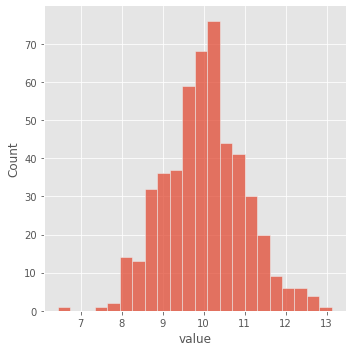

In [99]:
sns.displot(df_control.value)

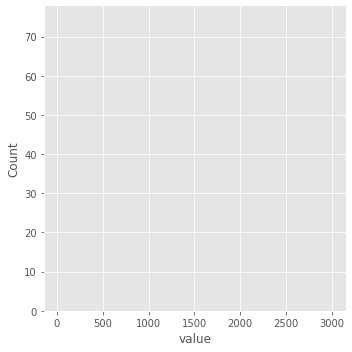

In [100]:
sns.displot(df_test_emissions.value)

При построение гистограммы тестовой группы, что-то идет не так.

In [101]:
df_test_emissions

,Unnamed: 0,value,experimentVariant
500,501,10.380495,Treatment
501,502,9.546867,Treatment
502,503,11.088215,Treatment
503,504,10.147274,Treatment
504,505,9.789808,Treatment
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


Видим, что последние значения в тестовой группе очень большие, что возможно приводит к пустой картинке на гистограмме.\
Пробуем строить barplot.

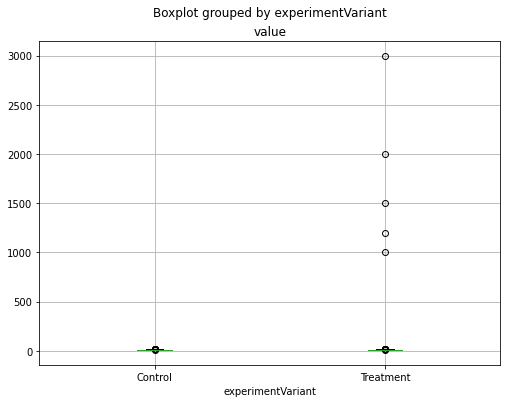

In [33]:
df.boxplot(column='value', by='experimentVariant',
                   figsize=(8, 6))

Видим, что на barplot у нас имеются выбросы.\
В контрольной группе мы видим что значения находятся в пределах значений от 5 до 15\
Попробуем оценить количество значений больше 20

In [102]:
df_test_emissions.query('value >= 20')

,Unnamed: 0,value,experimentVariant
995,996,1000.0,Treatment
996,997,1200.0,Treatment
997,998,1500.0,Treatment
998,999,2000.0,Treatment
999,1000,3000.0,Treatment


В таблице мы видим что таких значений 5 и их значения находятся в пределах 1000 и больше.\
Можем предположить что это ошибка измерения.\
Можем исключить эти значения из тестовой группы и еще раз посторить гистограмму.

In [46]:
df_test = df.query('experimentVariant == "Treatment" and value <= 20')

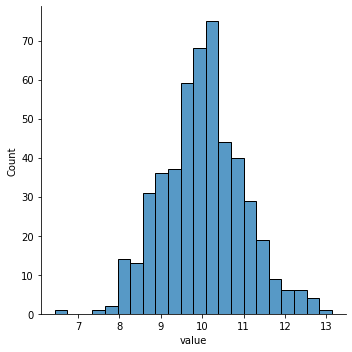

In [47]:
sns.displot(df_test.value)

Все получилось напревый взгляд гистограммы одинаковые.

/opt/tljh/user/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


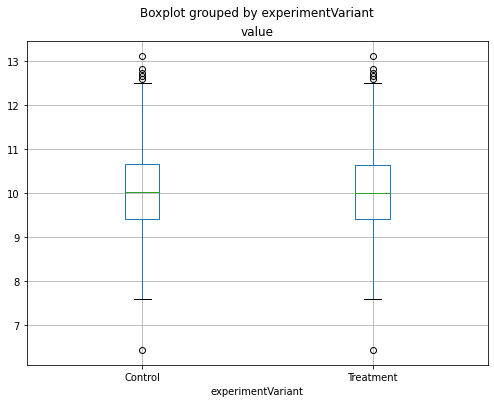

In [48]:
df.query ('value <= 20').boxplot(column='value', by='experimentVariant',
                   figsize=(8, 6))

 - Визуально можно предположить, что две эти выборки схожи.
 
#### Проверка гипотез с помощью разных статистических критериев

*Проверим эту гипотезу с помощью Бутстрап.*

In [116]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    statistic, # интересующая нас статистика
    boot_it = 1000, # количество бутстрэп-подвыборок
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

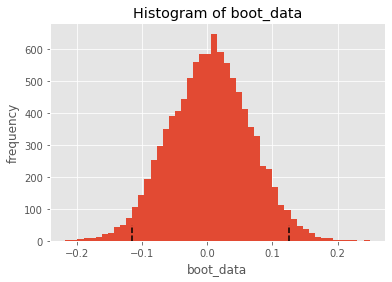

In [146]:
booted_data_mean = get_bootstrap(df_control.value, df_test.value, np.mean, boot_it = 10000) # в результате хранится разница двух распределений, ДИ и pvalue

In [147]:
booted_data_mean["p_value"].round(3)

0.945

In [148]:
booted_data_mean["ci"]

,0
0.025,-0.115028
0.975,0.124749


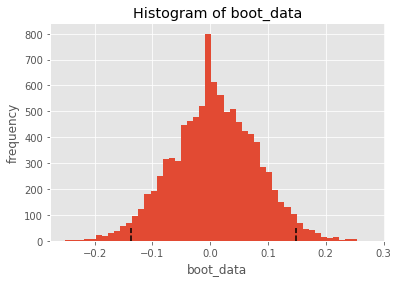

In [149]:
booted_data_median = get_bootstrap(df_control.value, df_test.value, np.median, boot_it = 10000) 

In [150]:
booted_data_median["p_value"]

0.9165920139836163

In [151]:
booted_data_median["ci"]

,0
0.025,-0.136514
0.975,0.148678


*Сравним две группы выборки с помощью критерия mann-whitney*

In [152]:
results = mannwhitneyu(df_control['value'], df_test['value'])

In [153]:
results[1].round(3)

0.923

In [154]:
# посмотрим на сколько % отличаются значения p-value бутстрап и mann-whitney
(booted_data_median["p_value"] - results[1]) / booted_data_median["p_value"]

-0.006815041300634517

In [155]:
(booted_data_mean["p_value"] - results[1]) / booted_data_mean["p_value"]

0.02347606705716482

##### Попробуем сравнить контрольную и тестовую группу с выбросами 

*Бутстрап для среднего значения выборки*

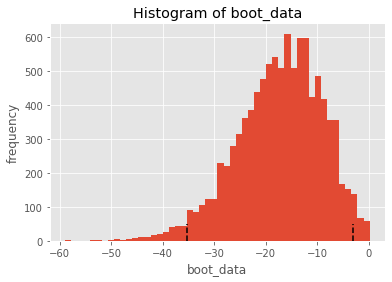

In [134]:
booted_data_mean_emissions = get_bootstrap(df_control.value, df_test_emissions.value, np.mean, boot_it = 10000)

In [138]:
booted_data_mean_emissions["p_value"].round(3)

0.036

In [136]:
booted_data_mean_emissions["ci"]

,0
0.025,-35.203683
0.975,-3.027124


*Бутсрап для медианного значения*

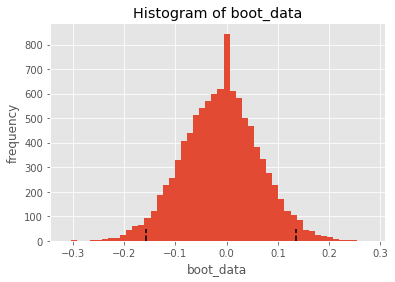

In [129]:
booted_data_median_emissions = get_bootstrap(df_control.value, df_test_emissions.value, np.median, boot_it = 10000)

In [130]:
booted_data_median_emissions["p_value"]

0.8826635961195466

In [131]:
booted_data_median_emissions["ci"]

,0
0.025,-0.158055
0.975,0.135235


*mann-whitney для групп с выбросами*

In [132]:
results_emissions = mannwhitneyu(df_control['value'], df_test_emissions['value'])

In [142]:
results_emissions[1].round(3)

0.859

In [157]:
(booted_data_median_emissions["p_value"] - results_emissions[1]) / booted_data_median_emissions["p_value"]

0.026565883054514017

### Выводы


- Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
- Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
- Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
- U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы
